In [1]:
import numpy as np
import xgboost as xgb
import pickle
from sklearn.metrics import confusion_matrix
import sail
import matplotlib.pyplot as plt

In [2]:
num_parties = 3

In [3]:
vm1 = sail.connect("127.0.0.1", 7001, "marine@terran.com", "sailpassword")
vm2 = sail.connect("127.0.0.1", 7002, "marine@terran.com", "sailpassword")
vm3 = sail.connect("127.0.0.1", 7003, "marine@terran.com", "sailpassword")
vmlist = [vm1, vm2, vm3]

In [4]:
fn_preprocess = sail.registerfn("sub_preprocessing.py", 1, 3)[0]
fn_handlehash = sail.registerfn("sub_handle_hashfn.py", 2, 1)[0]
fn_train_init = sail.registerfn("sub_training_init.py", 5, 1)[0]
fn_train_update = sail.registerfn("sub_training_one_boost.py", 6, 1)[0]
fnlist = [fn_preprocess, fn_handlehash, fn_train_init, fn_train_update]

In [5]:
for fn in fnlist:
    for vm in vmlist:
        sail.pushfn(vm, fn)

In [6]:
X=[]
y=[]

for i in range(num_parties):
    jobid1 = sail.newguid()
    sail.pushdata(vmlist[i], jobid1, fn_preprocess, [0], "/home/jjj/playground")
    sail.execjob(vmlist[i], fn_preprocess, jobid1)
    result = sail.pulldata(vmlist[i], jobid1, fn_preprocess, "/home/jjj/playground")
    X.append(result[0])  #X
    y.append(result[1])  #y

In [7]:
feature_dim = len(X[0][0])

In [8]:
params = {'max_depth': 8 }
dtrain_all = xgb.DMatrix(np.asarray([np.zeros(feature_dim)]), label=np.asarray([0]))
model = xgb.Booster(params, [dtrain_all])

In [9]:
num_dim = len(X[0][0])
r = 4.0
L = min(40, num_dim-1)
mu = 0.0
sigma = 1.0
hash_functions = []
for l in range(L):
    hash_function = []
    np.random.seed(0)
    a = np.random.normal(mu, sigma, num_dim)
    b = np.random.uniform(0, r, 1)
    hash_function.append(a)
    hash_function.append(b)
    hash_functions.append(hash_function)
params_hash_functions = {}
params_hash_functions['num_dim'] = num_dim
params_hash_functions['r'] = r
params_hash_functions['L'] = L
params_hash_functions['mu'] = mu
params_hash_functions['sigma'] = sigma
params_hash_functions['hash_functions'] = hash_functions

In [10]:
all_hashes = []
all_counters = []

for i in range(num_parties):
    jobid2 = sail.newguid()
    sail.pushdata(vmlist[i], jobid2, fn_handlehash, [X[i], params_hash_functions], "/home/jjj/playground")
    sail.execjob(vmlist[i], fn_handlehash, jobid2)
    result = sail.pulldata(vmlist[i], jobid2, fn_handlehash, "/home/jjj/playground")
    all_hashes.append(result[0]['hash_values'])
    all_counters.append(result[0]['counters'])

In [11]:
hash_tables = []
for m in range(num_parties):
    hash_table = np.zeros((len(all_hashes[m]), num_parties)) #For each party, build a hash table of dim numInstances x numParties.
    for i in range( len(all_hashes[m]) ):#Select an instance x_i in m party
        for j in range(num_parties):  #Select parties to find global instances from
            if j == m:
                hash_table[i][j] = i
            else:
                instance_hash_counts = {}
                for k in range(len(all_counters[j])):   #Select instance k in other parties
                    instance_hash_counts[k] = 0
                    for value in all_counters[m][i].keys():  #Iterate through hash values of x_i^m
                        if all_counters[j][k][value] != 0:
                            instance_hash_counts[k] += min(all_counters[j][k][value], all_counters[m][i][value])
                hash_table[i][j] = max(instance_hash_counts, key=instance_hash_counts.get)
    hash_tables.append(hash_table)

In [13]:
for i in range(20):
    print("Training round %d"%i)
    training_node = i % num_parties
    local_gradients=[]
    for j in range(num_parties):
        train = {}
        train['training'] = training_node
        train['node_id'] = j
        train['num_parties'] = num_parties


        jobid3 = sail.newguid()
        sail.pushdata(vmlist[j], jobid3, fn_train_init, [X[j], y[j], train, model, hash_tables], "/home/jjj/playground")
        sail.execjob(vmlist[j], fn_train_init, jobid3)
        result = sail.pulldata(vmlist[j], jobid3, fn_train_init, "/home/jjj/playground")
        local_gradients.append(result[0])
    
    for j in range(num_parties):
        train = {}
        train['training'] = training_node
        train['node_id'] = j
        train['num_parties'] = num_parties

        jobid4 = sail.newguid()
        sail.pushdata(vmlist[j], jobid4, fn_train_update, [X[j], y[j], train, model, local_gradients, hash_tables], "/home/jjj/playground")
        sail.execjob(vmlist[j], fn_train_update, jobid4)
        result = sail.pulldata(vmlist[j], jobid4, fn_train_update, "/home/jjj/playground")
        model = result[0]

Training round 0
Training round 1
Training round 2
Training round 3
Training round 4
Training round 5
Training round 6
Training round 7
Training round 8
Training round 9
Training round 10
Training round 11
Training round 12
Training round 13
Training round 14
Training round 15
Training round 16
Training round 17
Training round 18
Training round 19


In [14]:
vm4 = sail.connect("127.0.0.1", 7004, "marine@terran.com", "sailpassword")
fn_test = sail.registerfn("test.py", 4, 3)[0]
sail.pushfn(vm4, fn_test)
sail.pushfn(vm4, fn_preprocess)

In [15]:
jobid5 = sail.newguid()
sail.pushdata(vm4, jobid5, fn_preprocess, [0], "/home/jjj/playground")
sail.execjob(vm4, fn_preprocess, jobid5)
result = sail.pulldata(vm4, jobid5, fn_preprocess, "/home/jjj/playground")
test_X=result[0]
test_y=result[1]
df = result[2]

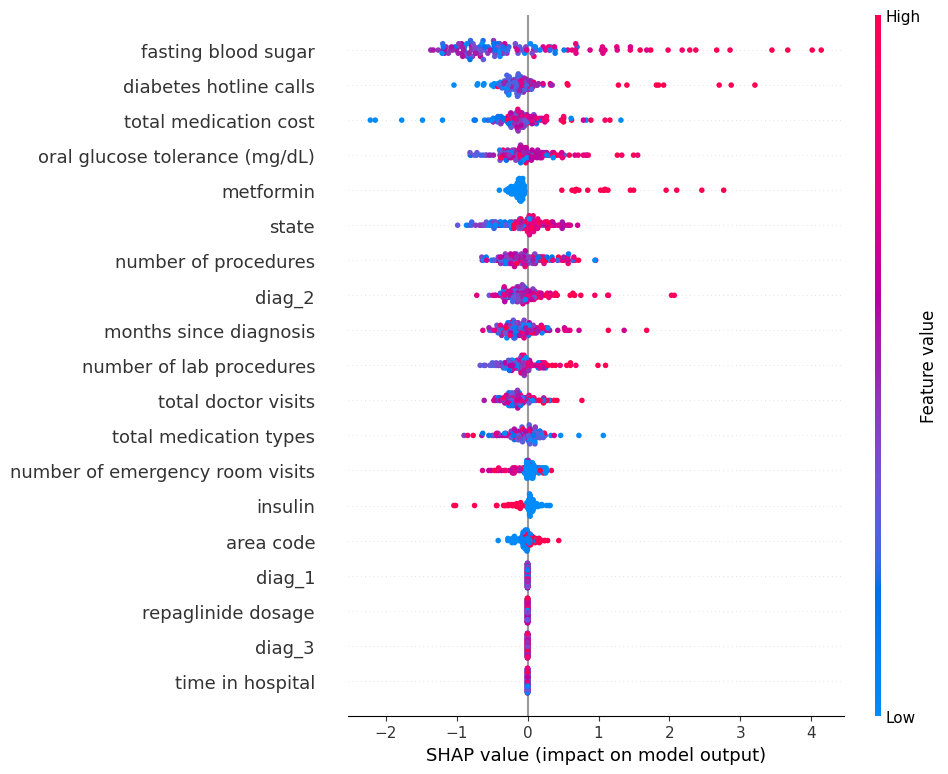

In [16]:
jobid6 = sail.newguid()
sail.pushdata(vm4, jobid6, fn_test, [test_X, test_y, df, model], "/home/jjj/playground")
sail.execjob(vm4, fn_test, jobid6)
result=sail.pulldata(vm4, jobid6, fn_test, "/home/jjj/playground")
conf_mat = result[0]
errors = result[1]
fig = result[2]

In [17]:
conf_mat

array([[110,   3],
       [  7,  14]])

In [18]:
errors

'error: 0.07462686567164178\nfalse negative rate: 0.3333333333333333\nfalse positive rate: 0.02654867256637168'

In [19]:
vm5 = sail.connect("127.0.0.1", 7005, "marine@terran.com", "sailpassword")
fn_pred_process = sail.registerfn("pred_process.py", 1, 1)[0]
fn_pred = sail.registerfn("pred.py", 2, 1)[0]
sail.pushfn(vm5, fn_pred_process)
sail.pushfn(vm5, fn_pred)

In [20]:
jobid7 = sail.newguid()
sail.pushdata(vm5, jobid7, fn_pred_process, [0], "/home/jjj/playground")
sail.execjob(vm5, fn_pred_process, jobid7)
result = sail.pulldata(vm5, jobid7, fn_pred_process, "/home/jjj/playground")
pred_X=result[0]

In [21]:
jobid8 = sail.newguid()
sail.pushdata(vm5, jobid8, fn_pred, [model, pred_X], "/home/jjj/playground")
sail.execjob(vm5, fn_pred, jobid8)
result = sail.pulldata(vm5, jobid8, fn_pred, "/home/jjj/playground")
pred_y=result[0]

In [22]:
pred_y

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)